In [1]:
from tasks import run_omm_with_celery 
from tasks import app

import numpy as np
import time
import GPUtil
import os 
import subprocess
import h5py 

from utils import start_worker, start_flower_monitor, omm_job, read_h5py_file

Using TensorFlow backend.


In [2]:
import time

In [3]:
import sys
sys.path.append('/home/hm0/Research/molecules/molecules_git/build/lib')
from molecules.utils.matrix_op import triu_to_full

In [4]:
from glob import glob

In [5]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% | 97% |


In [6]:
GPU_ids = [gpu.id for gpu in GPUtil.getGPUs()]

In [7]:
top_file = '/home/hm0/Research/molecules/MD_CVAE/P27-all/C1B48/C1B48.top.gz'
pdb_file = '/home/hm0/Research/molecules/MD_CVAE/P27-all/C1B48/C1B48.pdb.gz'

In [8]:
start_worker(app)
# start_flower_monitor()

<Thread(Thread-4, started 139720660416256)>

## Jobs
* Assign job_id according to the available GPUs on the board. 
* Start the simulation according the job_labels containing job_id and gpu_id for individual jobs 

In [9]:
jobs = []
for gpu_id in GPU_ids: 
    job = omm_job(job_id=int(time.time()), gpu_id=gpu_id, top_file=top_file, pdb_file=pdb_file)
    job.start() 
    jobs.append(job) 
    time.sleep(2)

# Read the output h5 files

In [10]:
cm_files = glob('*/*_cm.h5')

In [11]:
cm_data_lists = [read_h5py_file(cm_file) for cm_file in cm_files]

In [12]:

for cm in cm_data_lists: 
    print cm.shape

(1326, 2175)
(1326, 2046)
(1326, 90)
(1326, 94)
(1326, 21)


# Get updates from h5 file
Once every minute

# All contact to h5

In [13]:
def contact_concatenate(cm_data_lists): 
    cm_all = np.hstack(cm_data_lists)

    # transfer upper triangle to full matrix 
    cm_data_full = np.array([triu_to_full(cm_data) for cm_data in cm_all.T]) 

    # padding if odd dimension occurs in image 
    pad_f = lambda x: (0,0) if x%2 == 0 else (0,1) 
    padding_buffer = [(0,0)] 
    for x in cm_data_full.shape[1:]: 
        padding_buffer.append(pad_f(x))
    cm_data_full = np.pad(cm_data_full, padding_buffer, mode='constant')

    # reshape matrix to 4d tensor 
    cvae_input = cm_data_full.reshape(cm_data_full.shape + (1,))   
    
    return cvae_input

In [14]:
cvae_input = contact_concatenate(cm_data_lists)
cvae_input.shape

(4426, 52, 52, 1)

In [17]:
cvae_input = contact_concatenate(cm_data_lists)
cvae_input_save = h5py.File('./cvae_input.h5', 'w')
cvae_input_save.create_dataset('contact_maps', data=cvae_input)
cvae_input_save.close()

In [16]:
cvae_input_save = h5py.File('./cvae_input.h5', 'r')
cvae_input_save.close()

IOError: Unable to open file (file signature not found)

In [29]:
from run_cvae import run_cvae

In [30]:
cvae = run_cvae(0, 0, './cvae_input.h5')

In [28]:
train_data.shape  

(1326, 4221)

In [32]:
cvae_job = cvae_job()

In [43]:
import matplotlib.pyplot as plt

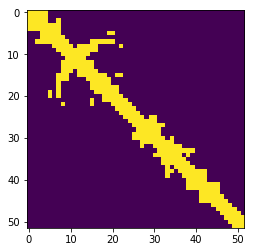

In [44]:
plt.imshow(triu_to_full(cm_ [0][u'contact_maps']['100']))